**13장 – 텐서플로에서 데이터 적재와 전처리하기**

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [332]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [333]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

그리고 TensorFlow ≥ 2.8:

In [334]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# 텐서플로 API를 사용해야하는 이유
- 소규모 데이터셋 : CSV 파일로 데이터를 탐색하고, 사이킷런 등을 사용해 전처리 작업을 수행
- 대용량 데이터셋 : 텐서플로(TensorFlow) 모델을 훈련할 때는 텐서플로의 데이터 로드 및 전처리 API인 tf.data를 사용하는 것이 더 효과적임
    - tf.data는 멀티스레드와 큐(queue)를 사용하여 여러 파일에서 동시에 데이터를 읽고, 셔플링(shuffling), 배칭(batching) 등의 작업을 빠르게 수행 가능
    - 현재 배치를 GPU에서 처리하는 동안, 여러 CPU 코어를 사용해 다음 배치를 동시에 로드하고 전처리할 수 있음
    - 메모리 크기를 초과하는 대용량 데이터셋도 처리할 수 있음
    - 하드웨어 리소스를 최적으로 활용할 수 있음
- TFRecord 포맷: TFRecord 데이터 포맷을 사용하면, 케라스(Keras) 모델에서 쉽게 사용할 수 있는 전처리 레이어를 활용할 수 있음

# 13.1 tf.data API

- tf.data API는 TensorFlow에서 효율적인 데이터 파이프라인을 구축하기 위한 도구
- 머신러닝 모델을 학습할 때, 대량의 데이터를 효율적으로 처리하고 변환하는 것은 매우 중요한데, 
tf.data API는 이러한 요구를 충족하도록 설계됨

- 이 API는 다양한 형식의 데이터를 다룰 수 있으며, 데이터를 전처리, 증강, 셔플링, 배칭, 캐싱 등의 작업을 체계적으로 처리함
- 특히, 데이터를 메모리, 디스크, 네트워크로부터 빠르게 불러오는 작업을 최적화해줌

- tf.data.Dataset은 데이터를 효율적으로 관리하는 기본 단위
- tf.data.Dataset.from_tensor_slices()를 사용해서 간단한 텐서로 데이터 생성

In [335]:
import tensorflow as tf

X = tf.range(10)  # 임의의 데이터 텐서
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [336]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


- 데이터셋에는 텐서 튜플, 이름/텐서 쌍의 딕셔너리도 포함 가능
- 슬라이싱할 때, 데이터셋 구조는 유지되고, 그 안에 포함된 텐서만 슬라이싱함

In [337]:
X_nested = {
    "a": ([1, 2, 3], [4, 5, 6]),  # 튜플 형태
    "b": [7, 8, 9]  # 리스트 형태
}

dataset = tf.data.Dataset.from_tensor_slices(X_nested)

# X_nested의 각 키에 대해 첫 번째 요소, 두 번째 요소, 세 번째 요소 등을 묶어서 반환
for item in dataset:
    print(item)

# {"a": (1, 4), "b": 7}
# {"a": (2, 5), "b": 8}
# {"a": (3, 6), "b": 9}

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## 13.1.1 연쇄 변환

데이터셋이 준비되면 여러 종류의 변환을 수행할 수 있다.

In [338]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10)) # 0부터 9까지의 정수를 포함하는 텐서를 생성 + 개별적으로 슬라이스
dataset = dataset.repeat(3).batch(7) # 데이터셋을 3번 반복 + 데이터셋의 항목을 7개씩 묶어서 배치를 만듬

for item in dataset:
    print(item)

# 0 1 2 3 4 5 6 7 8 9 0  1 2 3 4 5 6 7 8 9 0  1 2 3 4 5 6 7 8 9 와 같이 총 30개의 숫자를 생성하여 7개씩 묶음

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


map() 매서드를 활용

In [339]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


filter() 매서드 활용 (데이터 필터링할 수 있음)

In [340]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50) # 합이 50 보다 큰 배치만 담은 데이터셋
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


take() 매서드를 활용 (데이터셋에 있는 몇 개의 아이템만 보고 싶을 때)

In [341]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## 13.1.2 데이터 셔플링

In [342]:
dataset = tf.data.Dataset.range(10).repeat(2).batch(7) 
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int64)


In [343]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
# buffer_size=4는 데이터를 섞을 때 한 번에 4개의 요소만 메모리 상에서 섞는 버퍼 크기를 의미함
for item in dataset:
    print(item)

# ① [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]인 경우, 처음에 [0, 1, 2, 3]가 메모리에 올라감
# ② [0, 1, 2, 3]이 [3, 1, 0, 2]으로 셔플되면 3이 출력
# ③ 3이 빠지고, [1, 0, 2]에서 4가 추가되면 [1, 0, 2, 4]에서 다시 셔플.....반복.....

tf.Tensor([3 0 1 6 2 5 7], shape=(7,), dtype=int64)
tf.Tensor([8 4 1 9 4 2 3], shape=(7,), dtype=int64)
tf.Tensor([7 5 0 8 9 6], shape=(6,), dtype=int64)


### 13.1.3 여러 파일에서 한 줄씩 번갈아 읽기

캘리포니아 주택 데이터셋을 로드하고 준비해 보겠습니다. 먼저 데이터셋을 로드한 다음 훈련 세트, 검증 세트, 테스트 세트로 분할합니다:

In [344]:
# 추가 코드 - 캘리포니아 주택 데이터셋을 가져오고, 분할하고, 정규화합니다.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing() #  캘리포니아 주택 가격 데이터셋을 로드


# X_train_full, y_train_full에는 훈련용 데이터와 타겟이, X_test, y_test에는 테스트용 데이터와 타겟이 저장
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42) # 훈련 세트와 테스트 세트로 분할, 타겟 데이터(y)를 2차원 배열로 변환

# 훈련 세트를 훈련 세트와 검증 세트로 추가 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42) 

- 메모리에 맞지 않는 매우 큰 데이터셋의 경우, 일반적으로 먼저 여러 파일로 분할한 다음 텐서플로가 이 파일들을 병렬로 읽도록 합니다. 
- 이를 시연하기 위해 주택 데이터셋을 분할하여 20개의 CSV 파일로 저장

In [345]:
# 추가 코드 - 데이터셋을 20개 파일로 분할하여 CSV 파일로 저장합니다.

# 캘리포니아 주택 데이터셋을 훈련, 검증, 테스트 세트로 나눈 후, 각 세트를 여러 개의 CSV 파일로 저장합니다. 
# 각각의 CSV 파일은 열 이름을 포함하며, 훈련 세트는 20개, 검증 및 테스트 세트는 각각 10개 파일로 분할됩니다.

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10): # 데이터를 여러 개의 CSV 파일로 분할하여 저장하는 함수
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

이제 이 CSV 파일 중 하나의 처음 몇 줄을 살펴 보겠습니다:

In [346]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [347]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

**입력 파이프라인 구축하기**

In [348]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [349]:
# 추가 코드 - 파일 경로가 섞여 있음을 보여줍니다.
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', sh

In [350]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

# interleave()는 여러 데이터셋을 병렬로 처리하고, 교차(interleaved) 방식으로 데이터를 반환하는 함수
# lambda filepath: tf.data.TextLineDataset(filepath).skip(1) : 각 파일 경로 filepath에 대해 TextLineDataset을 사용하여 파일을 읽음
# cycle_length=n_readers : 한 번에 최대 5개의 파일을 병렬로 읽음

In [351]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159', shape=(), dtype=string)
tf.Tensor(b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)


## 13.1.4 데이터 전처리

In [352]:
# 추가 코드 - 각 특성의 평균 및 표준 편차 계산

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [353]:
##############################################
# CSV 파일에서 데이터를 파싱한 후 푲준화하는 과정
##############################################

X_mean, X_std = scaler.mean_, scaler.scale_  # X_train의 평균과 표준편차를 저장
n_inputs = 8 # 입력 데이터의 특성(feature) 수

def parse_csv_line(line): # CSV 파일에서 한 줄을 읽어와서 파싱하는 함수
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:]) # 피쳐, 타겟 구분

def preprocess(line): # 파싱된 데이터를 표준화 하는 함수
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y # 특성 표준화

In [354]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782') # 8개의 특성과 1개의 타겟 값

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## 13.1.5 데이터 적재와 전처리를 합치기

In [355]:
#######################################################################
# 텐서플로우의 tf.data API를 활용하여 여러 CSV 파일로부터 데이터를 불러오고, 
# 전처리, 배치 단위로 모델에 공급하는 데이터 파이프라인 구축
#######################################################################

def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10000, seed=42,
                       batch_size=32):
    
    # n_readers : 동시에 읽을 파일의 개수
    # n_parse_threads : CSV 라인을 파싱하고 전처리하는 작업에 사용할 스레드 수
    # shuffle_buffer_size : 셔플링할 때 사용할 버퍼 크기

    dataset = tf.data.Dataset.list_files(filepaths, seed=seed) # 파일 리스트를 셔플링
    
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    # dataset.interleave : 여러 파일을 동시에 읽고 처리
    # cycle_length=n_readers : 동시에 읽을 파일의 개수

    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed) # 데이터셋 셔플링
    
    return dataset.batch(batch_size).prefetch(1)
    # prefetch(1): 모델이 학습하는 동안 다음 배치를 미리 준비해 두는 명령어

In [356]:
example_set = csv_reader_dataset(train_filepaths, batch_size=3)

for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.2345318   0.1879177  -0.18384208  0.19340092 -0.4273575   0.49201018
   1.0838584  -1.3871703 ]
 [-1.3836461  -0.7613805  -0.3076956  -0.07978077 -0.05045014  0.32237166
   0.50294524 -0.1027696 ]
 [-0.41767654 -0.91959685 -0.5876468  -0.01253252  2.441884   -0.30059808
  -0.68699217  0.521939  ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.804]
 [0.53 ]
 [1.745]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.58831733  0.02970133 -0.70486885  0.16348003  0.8174406  -0.29916376
  -0.70573175  0.6568782 ]
 [-1.3526396  -1.868895   -0.84703934 -0.0277291   0.58563805 -0.10333684
  -1.3756571   1.2116159 ]
 [-0.16590534  1.8491895  -0.24013318 -0.0694841  -0.141711   -0.41202638
   0.994848   -1.4321475 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.045  ]
 [3.25   ]
 [5.00001]], shape=(3, 1), dtype=float32)



다음은 `Dataset` 클래스의 각 메서드에 대한 간단한 설명입니다:

In [357]:
#######################################################################
# tf.data.Dataset 관련 매서드
#######################################################################

for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● fingerprint()     

## 13.1.7 케라스와 데이터셋 사용하기

In [358]:
##############
# 데이터셋 준비
##############

train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [359]:
#########################################
# tf.keras.Sequential로 뉴런 모델 학습하기
#########################################

model = tf.keras.Sequential([ # 층(layer)을 순차적으로 쌓아 모델을 정의
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
                          # 30개의 뉴런
                          # 활성화 함수 : relu
                          #  He 초기화 방법을 사용해 가중치를 초기화
    tf.keras.layers.Dense(1),
    #  하나의 뉴런, 출력이 1차원 벡터이므로 회귀 문제
])
model.compile(loss="mse", optimizer="sgd") # 손실함수 mse, 확률적 경사하강법
model.fit(train_set, validation_data=valid_set, epochs=5) # 모델 훈련 중 검증 데이터 활용해서 모델성능 평가

Epoch 1/5


c:\Users\me\anaconda3\envs\lang310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    309/Unknown 0s 494us/step - loss: 8.4613

c:\Users\me\anaconda3\envs\lang310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7378 - val_loss: 31.6433
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.6908 - val_loss: 152.1924
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.7644 - val_loss: 0.6853
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.4990 - val_loss: 0.4148
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.4375 - val_loss: 0.3991


In [360]:
#########################
#  model.predict(new_set)
#########################

test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  
y_pred = model.predict(new_set)  
print(y_pred)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 0.4067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.6242751 ]
 [1.5586008 ]
 [1.8836071 ]
 [1.2781712 ]
 [4.4117794 ]
 [1.8945825 ]
 [1.6254563 ]
 [2.1506848 ]
 [1.6074376 ]
 [1.5237162 ]
 [1.6069956 ]
 [0.7011447 ]
 [3.8153305 ]
 [2.3296318 ]
 [1.0180621 ]
 [1.4176614 ]
 [1.5651584 ]
 [2.4546585 ]
 [1.809082  ]
 [2.9338698 ]
 [1.5557775 ]
 [1.7744074 ]
 [1.6895881 ]
 [2.0155144 ]
 [2.3827305 ]
 [3.9975085 ]
 [3.0394263 ]
 [1.6333833 ]
 [2.9283156 ]
 [1.0689377 ]
 [3.6015577 ]
 [1.7281415 ]
 [4.120286  ]
 [0.4002486 ]
 [1.7512393 ]
 [0.9681949 ]
 [2.4029193 ]
 [0.97106963]
 [1.4328701 ]
 [0.87581253]
 [0.78178024]
 [2.3812366 ]
 [0.26438457]
 [1.3688734 ]
 [3.469975  ]
 [1.9108816 ]
 [1.5082996 ]
 [1.4467833 ]
 [3.2366061 ]
 [0.8668866 ]
 [2.261407  ]
 [2.357626  ]
 [1.1527375 ]
 [3.2103314 ]
 [0.9296076 ]
 [1.2511793 ]
 [2.3291767 ]
 [3.0470662 ]
 [1.2353586 ]
 [1.8275099 ]
 [2.2563992 ]
 [1.0592027 ]
 [0.90695214]
 [1.3862323 ]
 [2.0425296 ]
 [1.5567616 ]
 [1.8998907 ]
 [2.329797  ]
 [0.951744 

In [361]:
#########################################
# 훈련을 위한 옵티마이저 및 손실 함수를 정의
#########################################

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch) # 예측값 y_pred를 계산
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred)) # 예측값 + 잔차 계산
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [362]:
###################################################
#  @tf.function 데코레이터를 사용하여 연산속도 줄이기 
###################################################

@tf.function
# @tf.function 데코레이터를 사용하면 연산 속도가 빨라지는 이유는 
# TensorFlow가 해당 함수의 실행을 "그래프 모드"로 변환하기 때문임

# 즉시 실행 모드 vs 그래프 모드
# 즉시 실행 모드 : 코드가 작성된 순서대로 명령을 하나씩 실행 (디버깅 용이)
# 그래프 모드 : 함수 내부의 모든 연산을 TensorFlow 계산 그래프로 변환
#              전체 연산의 흐름을 미리 정의하여 실행 시점에 최적화된 방법으로 연산


# 데이터셋 train_set을 사용해 모델을 한 번의 에포크 동안 훈련시킴
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape: # 그래디언드를 기록하는 컨텍스트
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables) # 손실 함수에 대한 모델 가중치의
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# 확률적 경사 하강법(SGD) 최적화 알고리즘을 정의
# 학습률(learning rate)은 0.01로 설정
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

# 지정된 epoch만큼 모델 훈련
n_epochs = 5
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

# 14.2s vs 1.2s

Epoch 5/5

# 13.2 TFRecord 포맷

- 대용량 데이터를 저장하고 효율적으로 익기 위해서 텐서플로가 선호하는 포맷 : TFRecord
- TFRecord는 크기가 다른 연속된 이진 레코드를 저장하는포맷
- `tf.io.TFRecordWriter`를 사용하여 TFRecord생성

In [363]:
##########################
# TFRecordWriter 객체 생성
##########################

with tf.io.TFRecordWriter("my_data.tfrecord") as f: 
    f.write(b"This is the first record") 
    f.write(b"And this is the second record")

그리고 `tf.data.TFRecordDataset`을 사용하여 읽을 수 있습니다:

In [364]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## 13.2.1 압축된 TFRecord 파일

TFRecord 파일 압축이 필요할 경우 (특히, 네트워트 사용 시)

In [365]:
###############
# 파일 압축하기
###############

options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [366]:
##################
# 압축된 파일 읽기
##################
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


## 13.2.2 프로토콜 버퍼 개요

- TFRecord
    - TFRecord는 TensorFlow에서 사용되는 이진 데이터 저장 형식
    - 특히 고속 데이터 읽기와 직렬화가 필요할 때 사용
    - 사용 방식: 데이터셋을 TFRecord 파일로 저장한 후, 이를 TensorFlow의 
                tf.data.TFRecordDataset API를 통해 쉽게 로드하여 훈련 데이터로 사용

- 프로토콜 버퍼 (Protocol Buffers)
    -  구글에서 개발한 언어 중립적이고 플랫폼 중립적인 데이터 직렬화 형식
    - 효율적으로 직렬화/역직렬화하는 데 사용
    - 사용 방식: 텐서플로의 데이터 직렬화 과정에서 주로 사용되며, TFRecord 파일에 데이터를 저장할 때 프로토콜 버퍼를 사용하여 데이터를 직렬화함

- TFRecord와 Protocol Buffers의 관계
    - TFRecord는 이진 포맷으로 데이터를 저장하는 형식이고, 이 데이터를 저장할 때 내부적으로 Protocol Buffers를 사용하여 데이터를 직렬화함
    - 즉, TFRecord는 Protocol Buffers로 직렬화된 데이터를 저장하는 컨테이너임
    - Protocol Buffers를 사용하여 데이터 구조를 정의하고, 데이터를 직렬화하여 TFRecord 파일로 저장
    - TensorFlow에서 TFRecord 파일은 Protocol Buffers로 직렬화된 데이터를 저장하는 용도로 사용

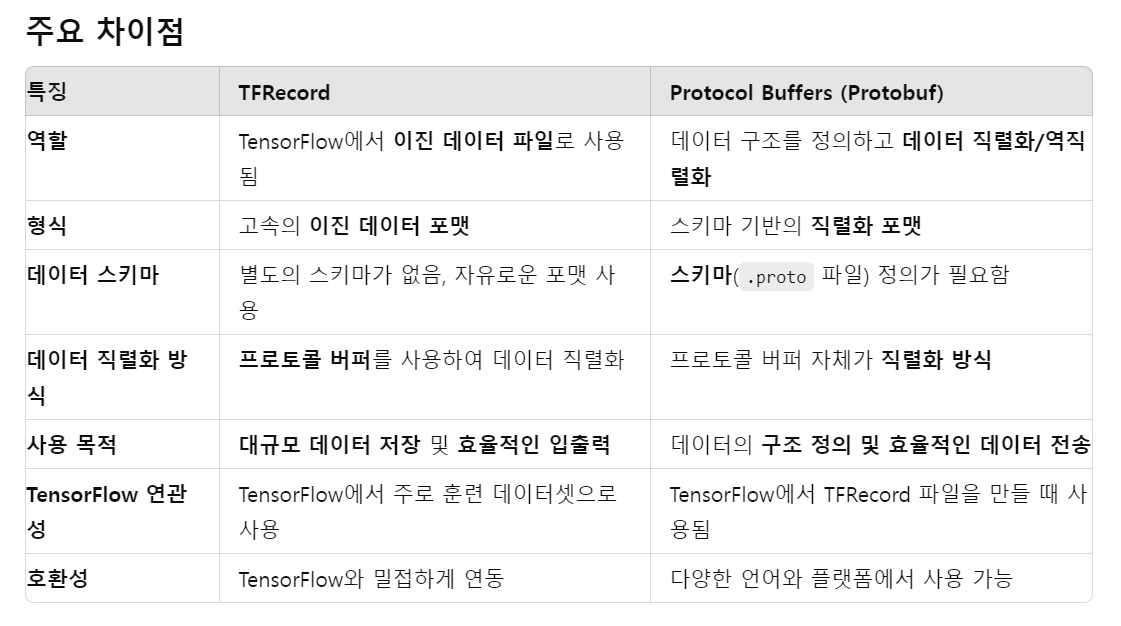

## 13.2.3 텐서플로 프로토콜 버퍼

- tf.train.Example 프로토콜 버퍼 란

  - 다양한 데이터 타입을 유연하게 저장할 수 있는 구조를 제공함
  - Feature 메시지의 oneof 필드를 사용하여 한 번에 하나의 데이터 타입만을 저장할 수 있고,  
    Features 메시지에서 여러 개의 Feature를 문자열 키로 구분하여 관리할 수 있습니다.
  - 각 특성은 바이트 문자열, 실수, 정수의 리스트 중 하나임

<텐서플로 소스코드에서 정의된 프로토콜 버퍼>

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

위와 Person과 동일하게 표현한 tf.train.Example 객체를 만드는 코드

In [367]:
#####################################
#  tf.train.Example 객체를 만드는 코드
#####################################

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

In [368]:
################################################################################
# Example 프로토콜 버퍼와 SerializeToString() 매서드로 결과데이터를 TFRecord에 저장
################################################################################
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

## 13.2.4 Example 프로토콜 버퍼 읽고 파싱하기

In [369]:
####################################################################################
# TFRecord 파일에서 데이터를 읽어와서 미리 정의된 스키마에 따라 각 데이터 항목을 파싱하여 
# 텐서플로우의 데이터셋으로 변환함 
####################################################################################


# 목적: TFRecord 파일에서 데이터를 읽을 때 사용할 피처의 스키마를 정의
# 변환된 데이터셋의 각 항목은 name, id, emails 필드를 가진 텐서로 구성
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

# 목적: TFRecord 파일에서 읽어온 데이터를 파싱하여 텐서플로우의 텐서로 변환
def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

# 목적: TFRecord 파일에서 데이터를 읽고, 이를 파싱하여 tf.data.Dataset 객체를 만듬
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)

# 파싱된 데이터를 출력
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

TensorFlow와 같은 머신 러닝 프레임워크에서 데이터를 저장하고 처리하는 두 가지 방식
방식에 따라 주로 메모리 사용량과 연산 효율성에 영향을 줌

- 밀집 텐서(dense tensor)
    - 밀집 텐서는 텐서의 모든 요소를 메모리에 저장하고 표현하는 방식
    - 장점: 연산이 간단하고 빠르며, 메모리에서 모든 값을 바로 접근할 수 있습니다.
    - 단점: 데이터가 희소(많은 0 또는 비어 있는 값)한 경우 메모리 낭비가 발생할 수 있습니다.

- 희소 텐서(sparse tensor)
    - 대부분의 값이 0이거나 비어 있는 데이터를 효율적으로 저장
    - 값이 존재하는 위치와 그 값을 리스트로 저장

밀집 텐서
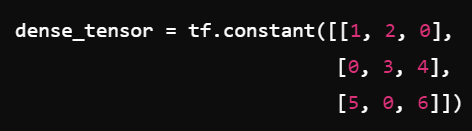

희소 텐서
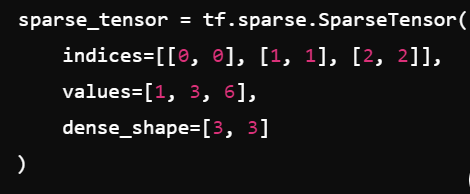

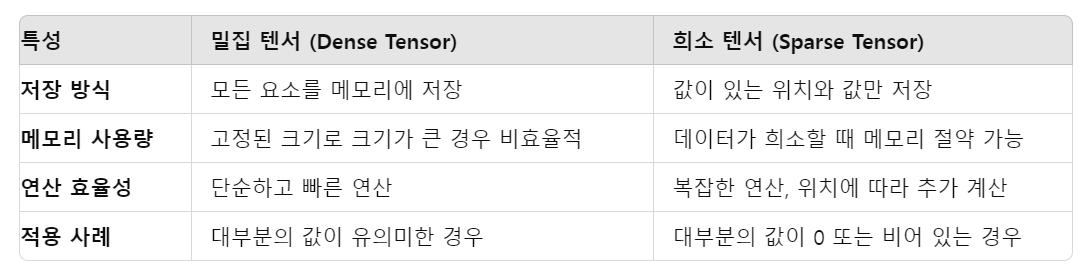

In [370]:
# 목적: 희소 텐서를 밀집 텐서로 변환
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [371]:
# 희소 텐서의 실제 데이터를 포함하고 있는 텐서를 반환
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [372]:
##########################################################################
# TFRecord 파일에서 데이터를 효율적으로 읽어와, 배치 단위로 파싱한 결과를 확인
##########################################################################

# 배치 단위로 데이터를 처리하기 때문에, 데이터셋의 크기가 크더라도 효율적으로 메모리를 
# 관리하면서 데이터를 로드하고 처리할 수 있습니다.

# 목적: tf.io.parse_example 함수를 사용하여 TFRecord 파일에서 읽어온 시리얼화된 예제들을 파싱
# 동작 : 시리얼화된 예제들을 feature_description이라는 스키마에 따라 파싱하여 텐서로 변환
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

# 목적 : TFRecord 파일에서 데이터를 읽어오고, 배치로 묶은 다음, 각 배치를 파싱
# 동작 : TFRecord 데이터셋을 생성 → 두개씩 묶어서 배치를 만듬 → 배치에 대해 parse함수 적용 
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)

for parsed_examples in dataset:
    print(parsed_examples) 

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=s

In [373]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

## 13.2.5 `SequenceExample` 프로토콜 버퍼를 사용해 리스트의 리스트 다루기

<SequenceExample 프로토콜 버퍼의 정의>
시퀀스 데이터와 그 시퀀스에 관련된 메타데이터(컨텍스트)를 함께 저장하기 위한 구조

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

- Feature는 FeatureList와 Features 메시지에서 사용되는 기본 데이터 단위
- FeatureList는 같은 종류의 데이터를 순차적으로 저장하는 리스트

In [374]:
############################################################
# 텍스트 데이터를 SequenceExample 형식으로 변환하기 위한 코드
# context는 시퀀스 데이터와 관련된 메타데이터를 저장하며, 
# feature_lists는 시퀀스 데이터를 시간적 순서에 따라 저장 
#############################################################

# 이 예제에서는 텍스트 데이터의 각 문장과 단어가 Feature로 변환되어 FeatureList에 저장되며, 
# 이를 통해 시퀀스 데이터를 효율적으로 표현할 수 있습니다.


from tensorflow.train import FeatureList, FeatureLists, SequenceExample

# context 정의
# 목적 : context는 시퀀스 전체와 관련된 전역 정보(메타데이터)를 저장
# Features : 여러 개의 Feature를 담고 있는 객체
context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

# 목적: 텍스트 데이터를 저장
# content는 글의 내용(문장 리스트), comments는 댓글(문장 리스트)을 포함
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

# 목적 : 단어 리스트를 Feature 형식으로 변환
# 동작 : 바이트 리스트를 Feature의 bytes_list 필드에 저장
def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

# 목적: content와 comments의 각 문장을 Feature 형식으로 변환하여 FeatureList를 생성
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

# 목적: context와 feature_lists를 포함하는 SequenceExample을 생성
sequence_example = SequenceExample(
    context=context, # 이전에 정의한 메타데이터(author_id, title, pub_date)가 포함
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [375]:
sequence_example

context {
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "content"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "shall"
          value: "we"
          value: "three"
          value: "meet"
          value: "again"
          value: "?"
        }
      }
      feature {
        bytes_list {
          value: "In"
          value: "thunder"
          value: ","
          value: "lightning"
          value: ","
          value: "or"
          value: "in"
          value: "rain"
          value: "?"
        }
      }
    }
  }
  feature_list {
    key: "c

In [418]:
#############################################################################
# 데이터를 저장하거나 전송하기 위해서
# SequenceExample 객체를 직렬화(serialize)하여 이진 문자열 형식으로 변환하는 코드
#############################################################################

serialized_sequence_example = sequence_example.SerializeToString()
print(serialized_sequence_example)

b"\nL\n\x14\n\x08pub_date\x12\x08\x1a\x06\n\x04\xd7\x0c\x0c\x19\n\x12\n\tauthor_id\x12\x05\x1a\x03\n\x01{\n \n\x05title\x12\x17\n\x15\n\x01A\n\x06desert\n\x05place\n\x01.\x12\xd0\x01\nb\n\x08comments\x12V\n&\n$\n\x04When\n\x03the\n\nhurlyburly\n\x02's\n\x04done\n\x01.\n,\n*\n\x04When\n\x03the\n\x06battle\n\x02's\n\x04lost\n\x03and\n\x03won\n\x01.\nj\n\x07content\x12_\n*\n(\n\x04When\n\x05shall\n\x02we\n\x05three\n\x04meet\n\x05again\n\x01?\n1\n/\n\x02In\n\x07thunder\n\x01,\n\tlightning\n\x01,\n\x02or\n\x02in\n\x04rain\n\x01?"


직렬화
- 데이터를 바이트 형식으로 변환하여 저장하는 과정

직렬화의 용도
- 저장: 직렬화된 데이터를 파일에 저장하여 나중에 다시 사용할 수 있습니다.
- 전송: 네트워크를 통해 데이터를 전송할 때, 직렬화된 포맷은 데이터를 작고 효율적으로 만듭니다.
- 복원: 필요할 때 직렬화된 데이터를 역직렬화하여 원래의 SequenceExample 객체로 복원할 수 있습니다.

직렬화와 역직렬화

In [ ]:
########
# 직렬화
########

# SerializeToString()
example = tf.train.Example(features=tf.train.Features(feature={
    "feature_name": tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
}))
serialized_example = example.SerializeToString()

# tf.io.serialize_tensor()
tensor = tf.constant([[1, 2], [3, 4]])
serialized_tensor = tf.io.serialize_tensor(tensor)

##########
# 역직렬화
##########

# tf.io.parse_single_example(): tf.train.Example 데이터를 원래 피처로 복원.
# tf.io.parse_single_sequence_example(): tf.train.SequenceExample 데이터를 복원.
# tf.io.deserialize_tensor(): 직렬화된 텐서를 원래 텐서로 복원.

In [377]:
##############################################################################################
# TensorFlow에서 데이터를 직렬화하고 역직렬화(디시리얼라이즈)하기 위한 텐서의 특징(feature)을 정의
##############################################################################################

# 목적: context 부분에 있는 메타데이터를 설명함
#       context는 SequenceExample에서 시퀀스 전체에 관련된 정보를 저장하는 필드임
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
} # 전체 데이터에 대한 메타데이터나 고정된 정보를 저장

# 목적 : feature_lists 부분에 있는 시퀀스 데이터를 설명함
#        feature_lists는 SequenceExample에서 시간적 순서가 있는 데이터를 저장하는 필드임
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
} # SequenceExample에서 시퀀스(시간에 따라 변화하는 데이터)를 저장하는데 사용됨

# 이 두 딕셔너리는 직렬화된 SequenceExample을 파싱할 때 사용됩니다. 
# 예를 들어, TensorFlow에서 tf.io.parse_single_sequence_example 함수를 사용할 때, 
# 이 딕셔너리를 인자로 전달하여 직렬화된 데이터에서 원하는 텐서를 추출할 수 있습니다.
# 이렇게 파싱된 데이터는 이후 모델 학습이나 예측에 사용할 수 있습니다.

In [378]:
# 직렬화된 SequenceExample을 파싱하여 텐서로 변환하여 context와 feature_lists 데이터를 추출
# ① serialized_sequence_example: 직렬화된 SequenceExample 데이터
# ② context_feature_descriptions: context 부분의 특징 설명 딕셔너리
# ③ sequence_feature_descriptions: feature_lists 부분의 특징 설명 딕셔너리
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions) # 역직렬화

# content 시퀀스 데이터를 희소 텐서에서 RaggedTensor로 변환
# RaggedTensor는 길이가 다른 시퀀스 데이터를 효율적으로 표현할 수 있는 TensorFlow의 자료 구조
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [379]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

- SparseTensor는 주로 희소 데이터(대부분의 값이 비어 있는 데이터)를 효율적으로 표현하기 위한 구조
- indices: 희소 텐서에서 실제 값이 있는 위치를 나타내는 인덱스
- values: 실제로 저장된 값
- dense_shape: 전체 텐서의 모양(shape)

# 13.3 케라스 전처리 층

## 13.3.1 `Normalization` 층

In [380]:
##########################################
# 정규화 레이어를 모델의 일부로 포함
##########################################

# 장점 : 검증 데이터에 대해서도 동일한 정규화가 적용
#      : 학습 데이터와 검증 데이터에 대해 동일한 정규화 처리를 수행을 보장함
# 매 에폭마다 전처리가 훈련됨

tf.random.set_seed(42)  
norm_layer = tf.keras.layers.Normalization() # 입력 데이터를 정규화하기 위한 레이어를 생성

model = tf.keras.models.Sequential([
    norm_layer, # 첫번째 레이어
    tf.keras.layers.Dense(1)]) # 두번째 레이어, 하나의 뉴런(선형회귀)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3)) # 모델 컴파일

#  X_train 데이터로 평균과 표준편차를 계산하고, 이 값을 기준으로 입력 데이터를 정규화하는 방법을 설정
norm_layer.adapt(X_train)   

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - loss: 4.3957 - val_loss: 2.2533
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 1.0329 - val_loss: 0.8319
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.8002 - val_loss: 0.8591
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.7407 - val_loss: 0.8099
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.7025 - val_loss: 0.7743


In [381]:
###############################################
# 특징 : 데이터 전처리 단계에서 직접 정규화를 수행
###############################################

# 장점 : 한번만 정규화하면 됨, 훈련속도가 더 빠름
# 데이터 정규화가 모델 학습과정과 분리되어 있어서 
# 모델이 학습 데이터와 검증 데이터의 정규화 처리에 일관성을 보장할 수 없음

norm_layer = tf.keras.layers.Normalization() # 정규화 레이어를 생성
norm_layer.adapt(X_train) 
X_train_scaled = norm_layer(X_train) # 훈련 데이터를 정규화
X_valid_scaled = norm_layer(X_valid) # 검증 데이터를 정규화

In [382]:
tf.random.set_seed(42) 
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - loss: 3.9698 - val_loss: 0.9550
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 0.9051 - val_loss: 0.8765
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.7222 - val_loss: 0.7758
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 0.6826 - val_loss: 0.7522
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.6567 - val_loss: 0.7238
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.6364 - val_loss: 0.7002
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 0.6201 - val_loss: 0.6803
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.6070 - val_loss: 0.6637
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.5965 - val_loss: 0.6499
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.5880 - val_loss: 0.6384
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.5812 - val_loss: 0.6288
Epoch 12/100
363/36

In [383]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # (스케일링되지 않은) 새 인스턴스가 몇 개 있다고 가정합니다.
y_pred = final_model(X_new)  # 데이터를 전처리하고 예측을 수행합니다.

In [384]:
y_test[:3]

array([[0.477  ],
       [0.458  ],
       [5.00001]])

In [385]:
y_pred[:3]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.7217572],
       [1.7735609],
       [2.7331996]], dtype=float32)>

In [386]:
# Normalization 층이 없다고 가능하면 직접 만들 수 있음

class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # 0 나눗셈 방지
        return (inputs - self.mean_) / (self.std_ + eps)

In [387]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

## `Discretization` 층
-  연속적인 데이터를 범주형 데이터로 변환

In [388]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]]) # 데이터 생성

# 3case (18 미만, 18~50, 50이상)
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In [389]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3) # 3개의 자동 구간이 생성
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

## `CategoryEncoding` 층

TensorFlow와 NumPy를 사용하여 카테고리 인코딩을 수행하는 예제

In [390]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3) # num_tokens=3 : 인코딩할 카테고리의 수가 3개임을 의미함, 원-핫 인코딩으로 변환
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [391]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [392]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
encoded_result = onehot_layer(two_age_categories)

print(encoded_result.numpy())

[[1. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]]


In [393]:
# 각 카테고리 값의 빈도를 계산하는 카운트 인코딩
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [394]:
# num_tokens=6으로 설정하여 인코딩할 카테고리의 수를 6개로 늘림
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # 두 번째 특성에 3을 추가합니다.

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

## `StringLookup` 층

In [395]:
# TensorFlow의 StringLookup 레이어를 사용하여 문자열 데이터를 인코딩하는 예제

cities = ["Auckland", "Paris", "Paris", "San Francisco"]

# StringLookup 레이어를 생성하고, adapt 메서드를 사용하여 cities 리스트에 적응
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)

# 문자열 인코딩 (문자열을 정수 인덱스로 매핑하는 내부 사전을 생성)
encoded = str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

# 인코딩된 결과 출력
print("인코딩된 결과:")
print(encoded.numpy())

def print_encoded_results(strings, encoded_indices, lookup_layer):
    # 인덱스와 문자열 매핑을 가져옴
    vocab = lookup_layer.get_vocabulary()
    index_to_string = {index: string for index, string in enumerate(vocab)}
    
    # 결과 출력
    for string, index in zip(strings, encoded_indices):
        decoded_string = index_to_string.get(index[0], "OOV")  # OOV 처리
        print(f"'{string[0]}' -> 인덱스: {index[0]}, 매핑된 문자열: '{decoded_string}'")
        
# 보기 쉽게 출력
print("\n매핑 결과:")
input_strings = [["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]]
print_encoded_results(input_strings, encoded.numpy(), str_lookup_layer)

인코딩된 결과:
[[1]
 [3]
 [3]
 [0]]

매핑 결과:
'Paris' -> 인덱스: 1, 매핑된 문자열: 'Paris'
'Auckland' -> 인덱스: 3, 매핑된 문자열: 'Auckland'
'Auckland' -> 인덱스: 3, 매핑된 문자열: 'Auckland'
'Montreal' -> 인덱스: 0, 매핑된 문자열: '[UNK]'


In [396]:
# output_mode="one_hot" = 원-핫 인코딩 모드로 StringLookup 레이어를 생성

str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]], dtype=int64)>

In [397]:
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"], ["Baㅎ"], ["Baㅁ"]])

<tf.Tensor: shape=(7, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=int64)>

In [398]:
# OOV 인덱스 수를 5로 설정한 StringLookup 레이어 생성 및 적응
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5) # OOV 토큰의 인덱스 수를 5로 지정 (OOV(Out-Of-Vocabulary)란, 사전에 없는 단어)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

In [399]:
# TensorFlow의 StringLookup 레이어를 사용하여 문자열 데이터를 인코딩하는 예제

# cities = [["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"], ["Baㅎ"], ["Baㅁ"]]

# StringLookup 레이어를 생성하고, adapt 메서드를 사용하여 cities 리스트에 적응
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5) # OOV 토큰의 인덱스 수를 5로 지정 (OOV(Out-Of-Vocabulary)란, 사전에 없는 단어)
# str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)

# 문자열 인코딩 (문자열을 정수 인덱스로 매핑하는 내부 사전을 생성)
encoded = str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

# 인코딩된 결과 출력
print("인코딩된 결과:")
print(encoded.numpy())

def print_encoded_results(strings, encoded_indices, lookup_layer):
    # 인덱스와 문자열 매핑을 가져옴
    vocab = lookup_layer.get_vocabulary()
    index_to_string = {index: string for index, string in enumerate(vocab)}
    
    # 결과 출력
    for string, index in zip(strings, encoded_indices):
        decoded_string = index_to_string.get(index[0], "OOV")  # OOV 처리
        print(f"'{string[0]}' -> 인덱스: {index[0]}, 매핑된 문자열: '{decoded_string}'")
        
# 보기 쉽게 출력
print("\n매핑 결과:")
input_strings = [["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]]
print_encoded_results(input_strings, encoded.numpy(), str_lookup_layer)

인코딩된 결과:
[[5]
 [7]
 [4]
 [3]
 [4]]

매핑 결과:
'Paris' -> 인덱스: 5, 매핑된 문자열: 'Paris'
'Auckland' -> 인덱스: 7, 매핑된 문자열: 'Auckland'
'Foo' -> 인덱스: 4, 매핑된 문자열: '[UNK]'
'Bar' -> 인덱스: 3, 매핑된 문자열: '[UNK]'
'Baz' -> 인덱스: 4, 매핑된 문자열: '[UNK]'


## `Hashing` 층

- Hashing 레이어를 사용하여 문자열 데이터를 해싱하는 예제
- 해싱은 문자열을 고정된 크기의 정수 인덱스로 변환하는 방법

In [400]:
# 각 문자열은 해시 함수에 의해 0부터 9까지의 정수로 변환
# 해싱 함수의 특성상 서로 다른 문자열이 같은 해시 값을 가질 수 있음 (해시 충돌(Hash Collision))
hashing_layer = tf.keras.layers.Hashing(num_bins=10) # num_bins에 의해 결정된 범위 이내의 정수로 변환
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

## 임베딩을 사용해 범주형 특성 인코딩하기

In [401]:
import numpy as np
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
# input_dim=5: 입력 정수 인덱스의 범위는 0부터 4까지임, 설정값을 벗어나면 에러 발생
# output_dim=2: 각 정수 인덱스는 2차원 벡터로 변환되어 출력됨

embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00427623,  0.02132311],
       [-0.00495318, -0.01479186],
       [-0.00427623,  0.02132311]], dtype=float32)>

**경고**: 케라스 2.8.0([이슈 #16101](https://github.com/keras-team/keras/issues/16101)에는 `Sequential` 모델의 첫 번째 레이어로 `StringLookup` 레이어를 사용할 수 없는 버그가 있습니다. 다행히도 간단한 해결 방법이 있습니다. 첫 번째 레이어로 `InputLayer`를 추가하면 됩니다.

In [402]:
# 문자열 데이터를 정수 인덱스로 변환한 후, 이를 임베딩 벡터로 변환하는 예제
tf.random.set_seed(42)

ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]

str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
# StringLookup 레이어를 생성하고, adapt 메서드를 사용하여 ocean_prox 리스트에 적응
# 이 과정에서 문자열을 정수 인덱스로 매핑하는 내부 사전을 생성


# Sequential 모델을 생성하여, 문자열 데이터를 정수 인덱스로 변환한 후 임베딩 벡터로 변환
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
# InputLayer는 입력 데이터의 형태와 데이터 타입을 정의합 (여기서 입력은 문자열 데이터임)
# str_lookup_layer는 문자열을 정수 인덱스로 변환
# Embedding 레이어는 정수 인덱스를 2차원 임베딩 벡터로 변환
# input_dim은 str_lookup_layer의 어휘 크기이고, output_dim은 임베딩 벡터의 차원입니다.

lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

c:\Users\me\anaconda3\envs\lang310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00329549,  0.0040983 ],
       [-0.04696734,  0.01805491],
       [-0.00329549,  0.0040983 ]], dtype=float32)>

## 텍스트 전처리

In [403]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
# TextVectorization 레이어를 생성하고, adapt 메서드를 사용하여 train_data에 적응시킴
# 이 과정에서 레이어는 텍스트를 토큰화하고, 각 토큰을 정수 인덱스로 매핑하는 내부 사전을 생성함
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

In [404]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True) # ragged=True로 설정하여, 가변 길이의 텍스트 시퀀스를 처리
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

In [405]:
# output_mode="tf_idf"로 설정하여, 텍스트를 TF-IDF(Term Frequency-Inverse Document Frequency) 벡터로 변환
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [406]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [407]:
1 * np.log(1 + 4 / (1 + 1))

1.0986122886681098

# 사전 훈련된 언어 모델 구성 요소 사용하기

In [408]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

## 이미지 전처리 층

In [409]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

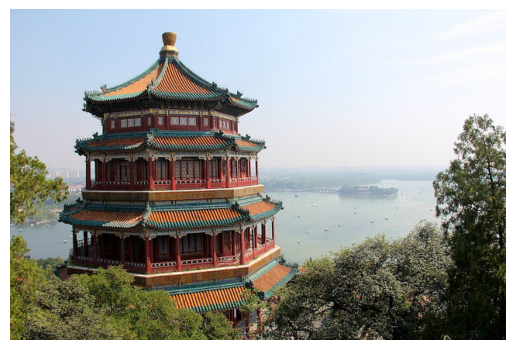

In [410]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

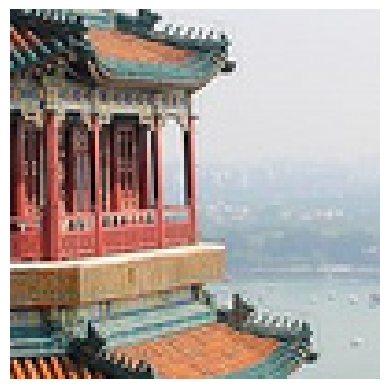

In [411]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

# 텐서플로 데이터셋

In [412]:
# MNIST 데이터셋 로드 & train/test 데이터셋 구분

import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [413]:
# mnist_train 데이터셋을 shuffle(), batch(), prefetch() 메서드를 사용하여 샘플링 및 전처리
# prefetch(1) : 데이터를 비동기적으로 미리 로드하여 학습 속도를 높임

for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]

In [414]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [415]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5


c:\Users\me\anaconda3\envs\lang310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.7593 - loss: 19.5182 - val_accuracy: 0.8743 - val_loss: 6.7401
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.8787 - loss: 5.8011 - val_accuracy: 0.8708 - val_loss: 6.5008
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.8831 - loss: 5.1571 - val_accuracy: 0.8812 - val_loss: 5.5713
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8873 - loss: 4.9809 - val_accuracy: 0.8918 - val_loss: 5.4672
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8885 - loss: 4.8682 - val_accuracy: 0.8845 - val_loss: 5.9686
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.8886 - loss: 5.3805
